In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as pat
import cv2
from io import BytesIO
import requests
!pip install facenet_pytorch
!pip install imutils youtube-dl

from facenet_pytorch import MTCNN
import torch
from imutils.video import FileVideoStream
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 1.9 MB 4.5 MB/s 
     |████████████████████████████████| 1.8 MB 8.6 MB/s 
  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=77610d53dbdcc015402e856a98286a90af92b986b364dc8e7f144481e9b5971a
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils


In [2]:
def get_boxes(file, result_list):
    plt.figure(figsize=(12,18))
    plt.imshow(file)
    ax = plt.gca()

    for result in result_list:
        x1, y1, x2, y2 = result
        rect = pat.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth = 2, color='red')
        ax.add_patch(rect)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [3]:
# Some images of IITB Team
img_url = ['http://iitb.ac.in/sites/default/files/EVo3.jpg',
           'http://www.alumni.iitb.ac.in/sites/default/files/news/2017-11/ASME%20SDC.jpg']
!mkdir Downloaded_Images
for i in range(len(img_url)):
    Image.open(BytesIO(requests.get(img_url[i]).content)).save('/kaggle/working/Downloaded_Images/image' + str(i) + '.png')

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


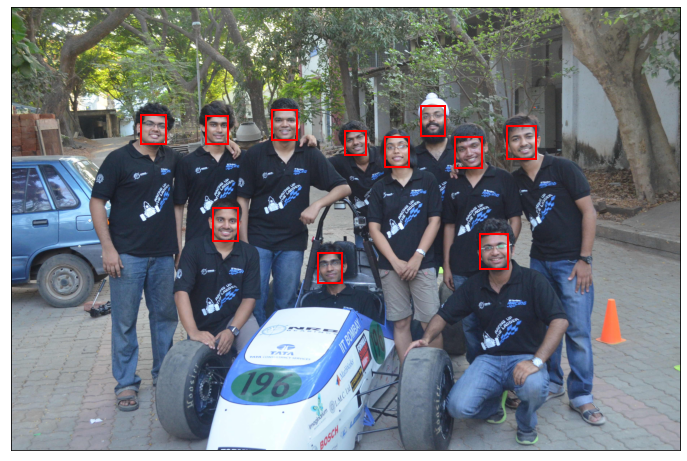

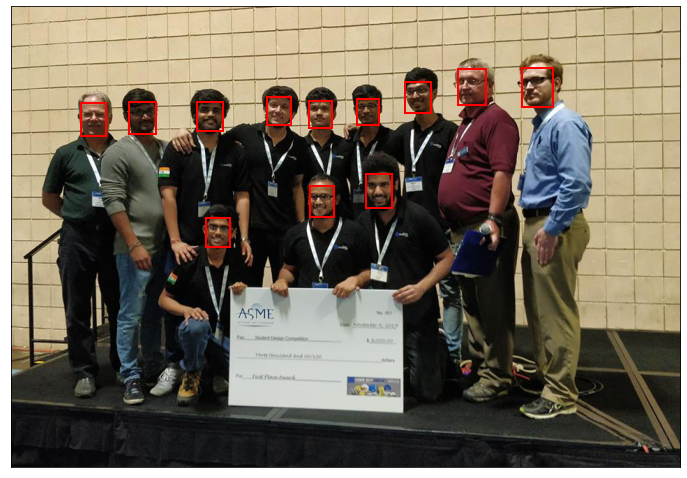

In [4]:
images = []
detector = MTCNN(device = device)
for i in range(len(img_url)):
    im = Image.open('/kaggle/working/Downloaded_Images/image' + str(i) + '.png')
    im = im.convert('RGB')
    im = np.asarray(im)
    images.append(im)
for im in images:
    faces = detector.detect(im)[0]
    get_boxes(im, faces)

In [5]:
!youtube-dl -f 'bestvideo[height=480]' https://www.youtube.com/watch?v=OTUn3iUvAX0 -o video.mp4
filename = '/kaggle/working/video.mp4'

[youtube] OTUn3iUvAX0: Downloading webpage
[youtube] OTUn3iUvAX0: Downloading js player 5253ac4d
[youtube] OTUn3iUvAX0: Downloading js player 5253ac4d
[download] Destination: video.mp4
[download] 100% of 12.70MiB in 00:00


In [6]:
v_cap = cv2.VideoCapture(filename)

v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

frames = []
for i in tqdm(range(v_len)):
    
    # Load frame
    success = v_cap.grab()
    if i % 2 == 0:
        success, frame = v_cap.retrieve()
    else:
        continue
    if not success:
        continue
        
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

In [7]:
faces = []
for x in tqdm(frames):
    temp = []
    result = detector.detect(x)[0]
    if np.any(result):
        for i in range(len(result)):
            temp.append(result[i])
        faces.append(temp)
    else:
        faces.append(temp)

In [8]:
def append_boxes(frame, faces):
    for f in faces:
        x1, y1, x2, y2 = int(f[0]), int(f[1]), int(f[2]), int(f[3])
        if x1 >= 854 or x2 >= 854 or y1 >= 480 or y2 >= 480:
            continue

        frame[y1, x1 : x2, 0] = 255
        frame[y1, x1 : x2, 1] = 0
        frame[y1, x1 : x2, 2] = 0
        
        frame[y2, x1 : x2, 0] = 255
        frame[y2, x1 : x2, 1] = 0
        frame[y2, x1 : x2, 2] = 0
        
        frame[y1 : y2, x1, 0] = 0
        frame[y1 : y2, x1, 1] = 0
        frame[y1 : y2, x1, 2] = 255
        
        frame[y1 : y2, x2, 0] = 0
        frame[y1 : y2, x2, 1] = 255
        frame[y1 : y2, x2, 2] = 0
        
    return frame

In [9]:
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 12, (854,480))
for i in tqdm(range(len(frames))):
    frame = cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR)
    frame = append_boxes(frame, faces[i])
    out.write(frame)
out.release()